In [2]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set(font_scale=2.5)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
df_train['FamliySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i : np.log(i) if i>0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i>0 else 0)

3. Feature engineering

    - 본격적인 feature engineering을 시작해보겠습니다.
    - 가장 먼저, dataset에 존재하는 null data를 채우려고함
    - 아무 숫자로 채울 수는 없고, null data를 포함하는 fearue의 statics를 참고하거나, 다른 아이디어를 짜내어 채울 수 있습니다.
    - null data를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지 될 수 있기 때문에, 신경써줘야할 부분입니다.
    - Feature engineering은 실제 모델의 학습에 쓰려고 하는 것이므로, train뿐만 아니라, test도 똑같이 적용해주어야 합니다.  
    잊지마세요

3.1 Fill Null

    3.1.1 Fill null in Age using title
        - Age에는 null data가 177개나 있습니다. 이를 채울 수 있는 여러 아이디어가 있을 건인데, 여기서 우리는 title + statistic을 사용해보도록 하겠습니다.
        - 영어에서는 miss, mr, mrs 와 같은 title이 존재합니다. 각 탑승객의 이름에는 꼭 이런 title이 들어가게되는 이를 사용해보도록 하겠습니다.
        - pandas series에는 data를 string으로 바꾸주는 str method, 거기에 정규표현식을 적용하게 해주는  extract method가 있습니다.
        이를 사용하여 title을 쉽게 추출할 수 잇습니다.
        - title을 initial column에 저장하겠습니다.

In [4]:
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')    # Lets extract the solutations
df_test['Initial']=df_test.Name.str.extract('([A-Za-z]+)\.')        # Lets extract the solutations

        -pandas의 corsstab을 이용하여 우리가 추출한 Initial과 Sex간의 count를 살펴봅시다.

In [5]:
# Checking the Initials with the Sex
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


        - 위 테이블을 참고하여 남자, 여자가 쓰는 initial을 구분해보곗습니다.
        replace 메소드를 사용하면 특정 데이터 값을 원하는 값으로 치환해줍니다

In [6]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)


In [7]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamliySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


        - 여성과 관계있는 Miss, Mr, Mrs 가 생존률이 높은 것을 볼 수 있다.

<Axes: xlabel='Initial'>

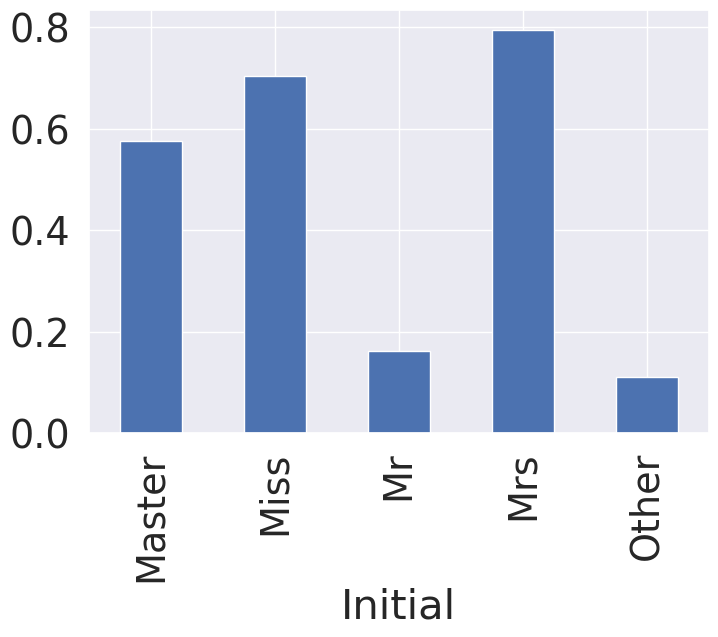

In [8]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

        - 이제 본격적으로 Null을 채울 것입니다.
        null data를 채우는 방법은 정말 많이 존재합니다.
        statistics를 활용하는 방법도 있고, null data가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있습니다.
        여기서는 statistics를 활용하는 방법을 사용할 것입니다.

        - 여기서 statistics는 train data의 것을 의미합니다.
        우리는 언제나 test를 unseen 으로 둔 상태로 놔둬야 하며, train에서 얻은 statistics를 기반으로 test의 null data를 채워줘야 합니다.

In [9]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamliySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


        - Age의 평균을 이용해 Null Value를 채우도록 하겠습니다.
        - pandas dataframe을 다룰때에는 boolean array를 이요해 indexing 하는 방법이 참으로 편리합니다.
        - 아래 코드 첫줄을 해석하자면, isnull()이면서 Initial이 Mr인 조건을 만족하는 row(탑승객)의 'Age'의 값을 33으로 치환한다 입니다.
        - loc + boolean + column을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해집시다.

In [10]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

        - 여기에서는 간단하게 NULL을 채웠지만, 좀 더 다양한 방법을 쓴 예시들이 다른 커널에 존재함
        - https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
        - 이 외에도 다른 캐글러들의 커널을 보며 여러 참신한 아이디어를 살펴보세요!

3.1.2 Fill Null in Embarked

In [11]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), 'Null values')

Embarked has  2 Null values


    - Embarked는 Null value가 2개이고, S에서 가장 많은 탑승객이 있었으므로, 간단하게 NUll을 S로 채움
    - dataframe의 fillna method를 이용하면 쉽게 채울 수 있음.
    여기서 inplace=True로 하면 df_train에 fillna를 실제로 적용하게 됨

In [12]:
df_train['Embarked'].fillna('S', inplace=True)